<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/combining_dips/NewModelAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 256kB 21.5MB/s 
     |████████████████████████████████| 25.2MB 161kB/s 
     |████████████████████████████████| 4.5MB 38.4MB/s 
     |████████████████████████████████| 2.7MB 43.0MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=c476abaeec7a72a385d9c5cb8e053e4207e38d34800b2cac88fdb337cec55dc6
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=0af01206dfeea2afd6fb790ab0113c95f080951b9bf5029a71ef6a5038fa5211
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=9524a2817074fe3f2af28e696fbc570b6d75b125d19f7a3f18fa2879bb49820e
  Stored in directory: /root/.cache/pip/wheels/a

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


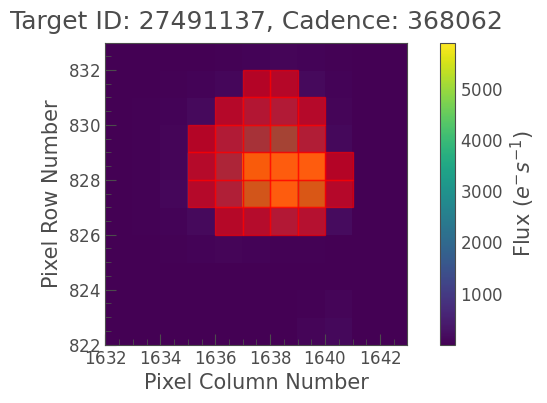

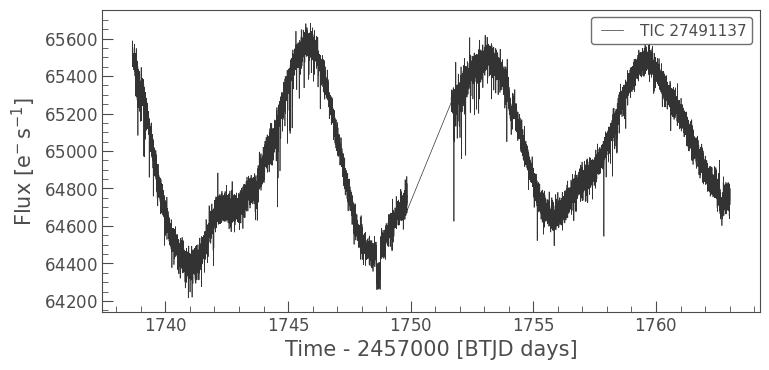

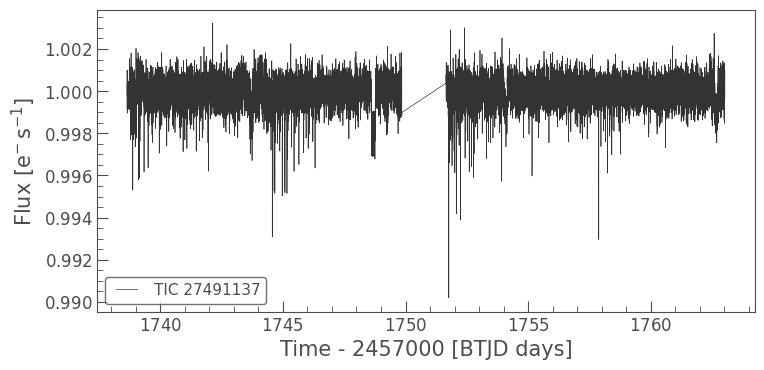

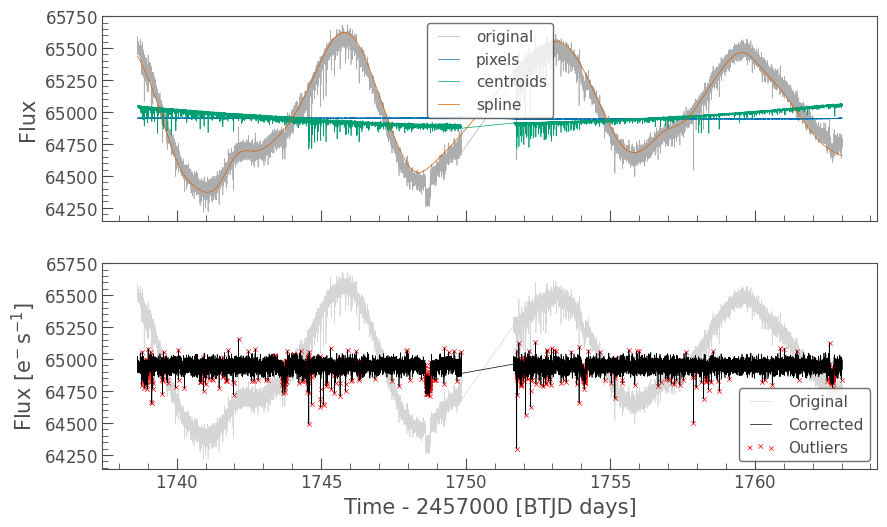

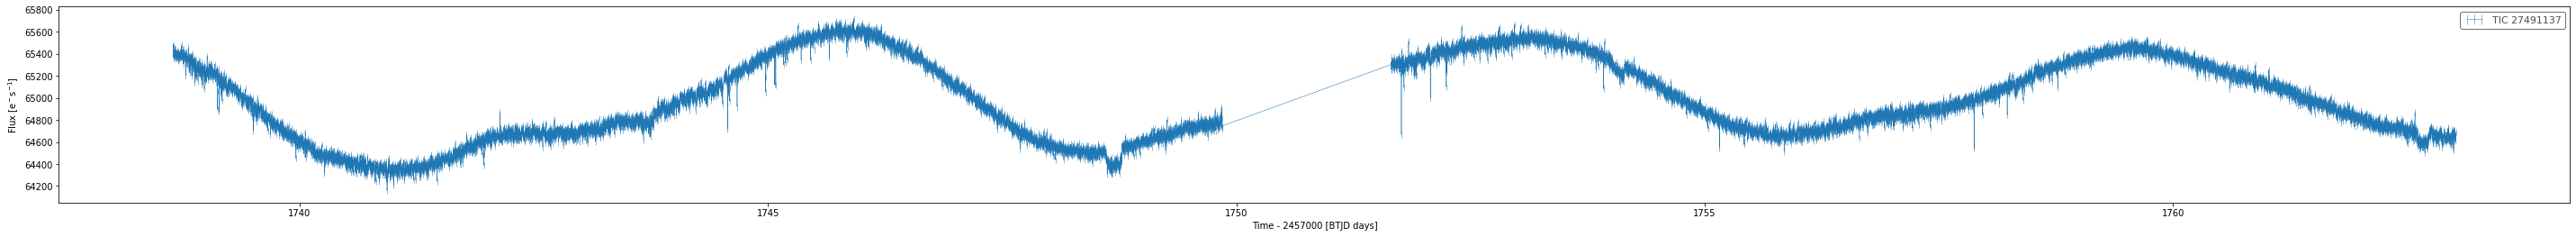

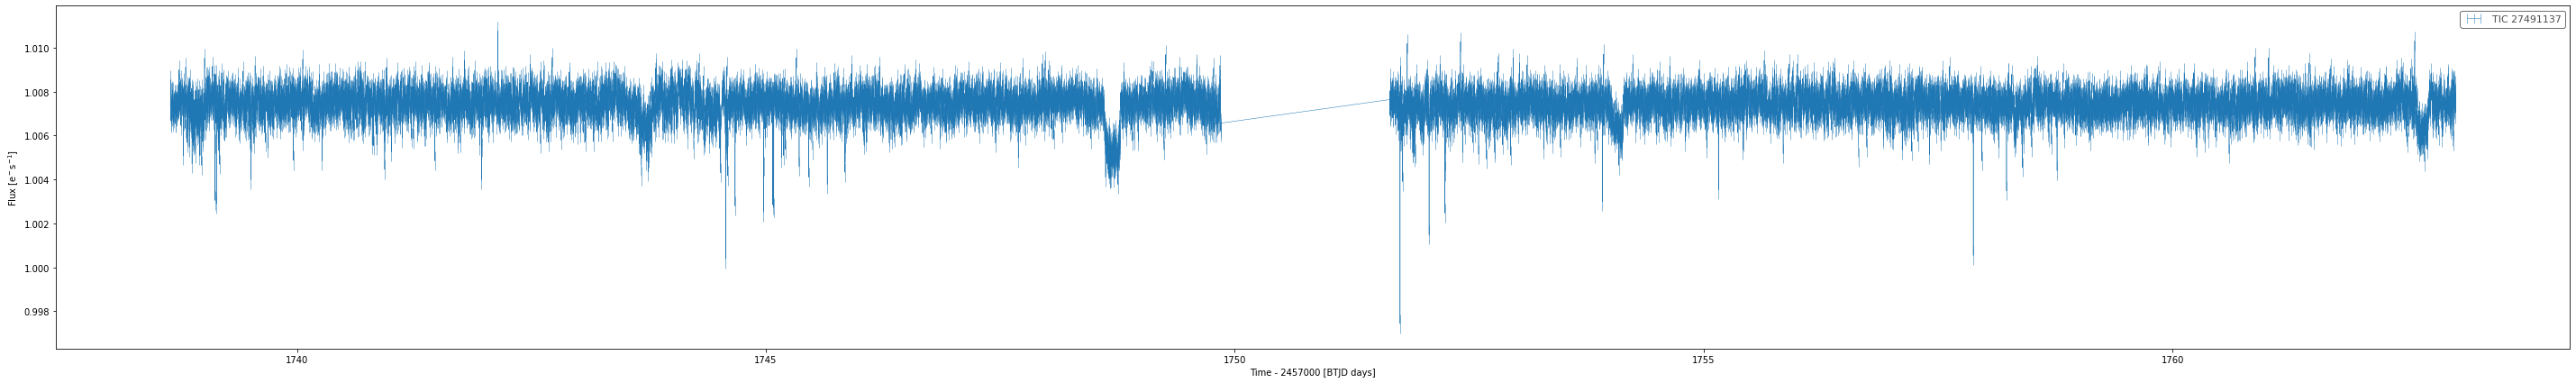

In [13]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

In [0]:
clean_lc = clc/stellar_flux

clean_lc = lk.LightCurve(np.asarray(clean_lc.time, np.float64),
                         np.asarray(clean_lc.flux, np.float64),
                         np.asarray(clean_lc.flux_err, np.float64))

In [0]:
import theano.tensor as tt
masks = [tt.as_tensor(np.in1d(np.arange(len(clc.flux)), np.arange(a, b)).astype(float)) for a, b in zip([3000, 6700, 9500, 15650], [4200, 7688, 10800, 16812])]

In [0]:
dips = [(clean_lc/mask.eval())[np.isfinite(1/mask.eval())] for mask in masks]

In [6]:
import pymc3 as pm
import exoplanet as xo
from exoplanet.gp import terms, GP
with pm.Model() as model:
    mean = pm.Normal("mean", mu=1, sd=0.01)

    log_sigma = pm.Uniform("log_sigma", lower=-10, upper=10)
    log_rho = pm.Uniform("log_rho", lower=-10, upper=10)

    # Set up the kernel an GP
    kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)
    gp = GP(kernel, clean_lc.time, clean_lc.flux_err ** 2)


    
    r_star = pm.Normal("r_star", mu=0.772148, sd=0.0454673, testval=0.78)    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval=0.87)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    tv = 1748.69
    t01 = pm.Uniform("t01", lower=tv-0.1, upper=tv+0.1)
    period1 = pm.Uniform("period1", lower=0, upper=200, testval=30)
    r1 = pm.Uniform("r1", lower=0.001, upper=0.1, testval=0.04)
    b1 = xo.distributions.ImpactParameter("b1", ror=r1/r_star)
    orbit1 = xo.orbits.KeplerianOrbit(period=period1, t0=t01, b=b1, r_star=r_star, m_star=m_star) 
    light_curve1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit1, r=r1, t=clean_lc.time)[:, 0]
    
    r2 = pm.Uniform("r2", lower=0.001, upper=0.1, testval=0.04)
    r3 = pm.Uniform("r3", lower=0.001, upper=0.1, testval=0.04)
    r4 = pm.Uniform("r4", lower=0.001, upper=0.1, testval=0.04)

    b2 = xo.distributions.ImpactParameter("b2", ror=r2/r_star)
    b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star)
    b4 = xo.distributions.ImpactParameter("b4", ror=r4/r_star)

    tv = 1743.72
    t02 = pm.Uniform("t02", lower=tv-0.1, upper=tv+0.1)

    tv = 1754.075
    t03 = pm.Uniform("t03", lower=tv-0.1, upper=tv+0.1)
    
    tv = 1762.67
    t04 = pm.Uniform("t04", lower=tv-0.1, upper=tv+0.1)
    
    period2 = ((t03 - t02) + (t04 - t03))/2
    
    orbit2 = xo.orbits.KeplerianOrbit(period=period2, t0=t02, b=b2, r_star=r_star, m_star=m_star) 
    light_curve2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit2, r=r2, t=clean_lc.time)[:, 0] * masks[0]

    orbit3 = xo.orbits.KeplerianOrbit(period=period2, t0=t03, b=b2, r_star=r_star, m_star=m_star) 
    light_curve3 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit3, r=r3, t=clean_lc.time)[:, 0] * masks[2]

    orbit4 = xo.orbits.KeplerianOrbit(period=period2, t0=t04, b=b2, r_star=r_star, m_star=m_star) 
    light_curve4 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit4, r=r4, t=clean_lc.time)[:, 0] * masks[3]

#     period3 = pm.Uniform("period3", lower=1, upper=200, testval=100)
#     r3 = pm.Uniform("r3", lower=0.001, upper=0.1, testval=0.01)
#     b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star)
#     t05 = pm.Bound(pm.Normal, lower=1743.55 - 0.1, upper=1743.55 + 0.1)("t05", mu=1743.55, sd=0.01, testval=1743.55) 
#     orbit5 = xo.orbits.KeplerianOrbit(period=period3, t0=t05, b=b3, r_star=r_star, m_star=m_star) 
#     light_curve5 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit5, r=r3, t=clean_lc.time)[:, 0]


    light_curve = pm.Deterministic('light_curve', light_curve1 + light_curve2 + light_curve3 + light_curve4 + mean)
    
    
#s    pm.Normal("obs1", mu=light_curve, sd=clean_lc.flux_err, observed=clean_lc.flux)
    
#     # Fit for the maximum a posteriori parameters given the simuated dataset
#     # Posterior distribution is usually given as Prior*Likelihood


    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=clean_lc.flux - light_curve)

    gp_pred = pm.Deterministic('gp_pred', gp.predict())


    
    map_soln = xo.optimize(start=model.test_point, vars=[log_sigma, log_rho])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, t03, t04, mean])
    map_soln = xo.optimize(start=map_soln, vars=[r1, r2])
    map_soln = xo.optimize(start=map_soln, vars=[period1])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, t03, t04, mean, r1, r2, period1, b1, b2, log_sigma, log_rho])
    

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

optimizing logp for variables: [mean, t04, t03, t02, t01]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 94740.49730050683 -> 94782.98092202791
optimizing logp for variables: [r2, r1]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 94782.98092202791 -> 94829.47607717203
optimizing logp for variables: [period1]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 94829.47607717203 -> 94829.93720373635
optimizing logp for variables: [log_rho, log_sigma, b2, r2, r_star, b1, r1, period1, mean, t04, t03, t02, t01]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 94829.93720373635 -> 94996.02553908621


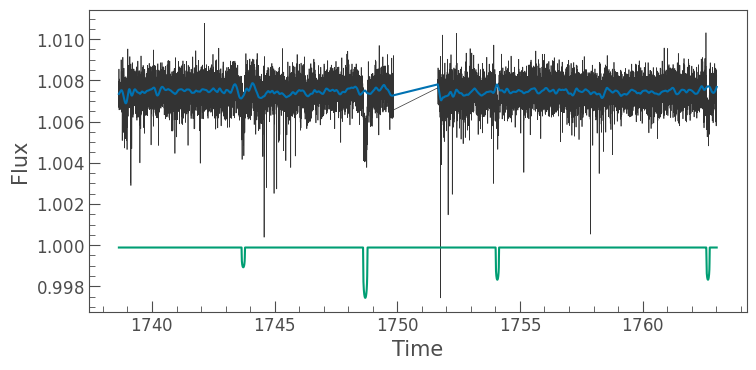

In [7]:
clean_lc.plot()
plt.plot(clean_lc.time, map_soln['gp_pred'] + map_soln['mean'])
plt.plot(clean_lc.time, map_soln['light_curve'])

In [8]:
lc.flux.shape

(16812,)

<Figure size 432x288 with 0 Axes>

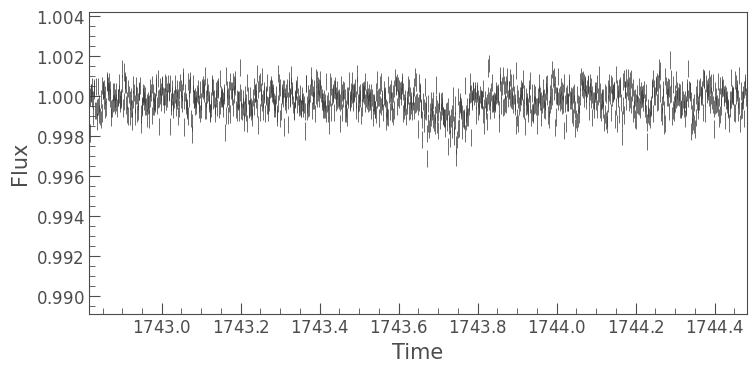

<Figure size 432x288 with 0 Axes>

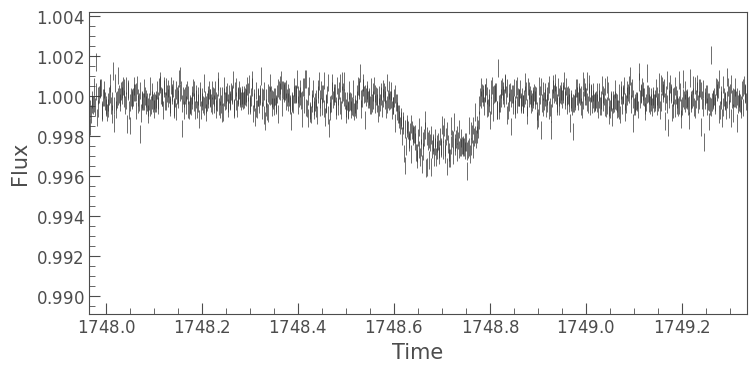

<Figure size 432x288 with 0 Axes>

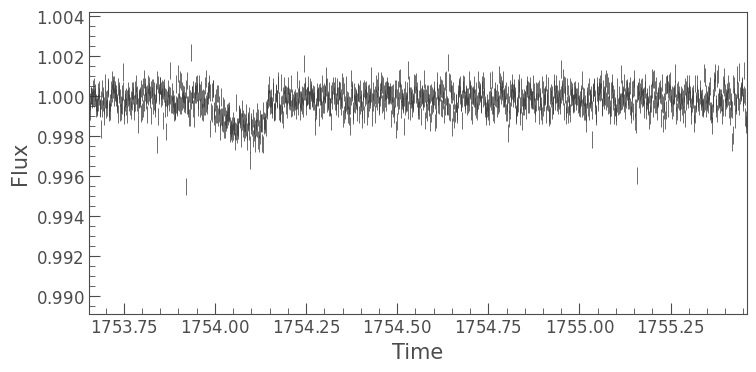

<Figure size 432x288 with 0 Axes>

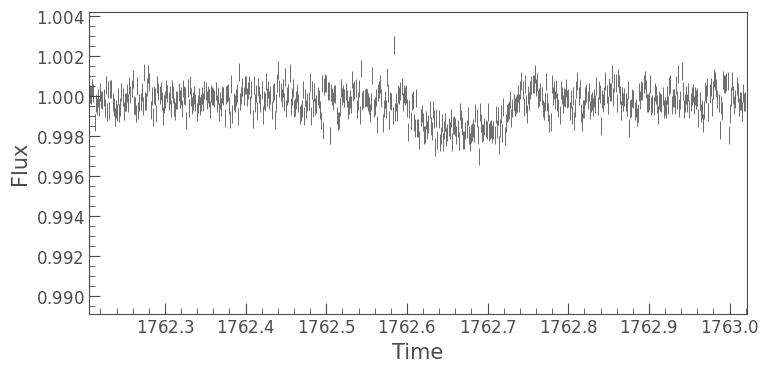

In [9]:
for d in dips:
    plt.figure()
    (clean_lc - (map_soln['gp_pred'])).errorbar()
    plt.xlim(d.time[0], d.time[-1])

In [10]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=500,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [t04, t03, t02, b4, b3, b2, r4, r3, r2, b1, r1, period1, t01, u, m_star, r_star, log_rho, log_sigma, mean]
Sampling chain 0, 0 divergences:  41%|████      | 618/1500 [30:08<12:43,  1.16it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:  41%|████      | 618/1500 [30:10<43:03,  2.93s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [0]:
labels = ['t01', 't02', 't03', 't04', 'mean',
          'period1',
          'r1', 'r2','r3','r4', 'b1', 'b2', 'u']

In [12]:
pm.summary(trace, varnames=labels)

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


ValueError: ignored

In [0]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=labels)
fig = corner.corner(samples)
fig.savefig('corner.png', dpi=200, bbox_inches='tight')


In [0]:
mu, lower, upper = np.percentile(trace['gp_pred'] + trace['light_curve'], [50, 16, 84], axis=0)

In [0]:
ax = clean_lc.errorbar()
ax.fill_between(clean_lc.time, lower, upper, zorder=10, color='r', alpha=0.7)


In [0]:
for d in dips:
    ax = clean_lc.errorbar(zorder=-1)
    ax.fill_between(clean_lc.time, lower, upper, zorder=10, color='r', alpha=0.7)
#    ax.plot(clean_lc.time, mu, zorder=10, color='r')

    ax.set_xlim(d.time[0], d.time[-1])

In [0]:
(((trace['t03'] - trace['t02']) + (trace['t04'] - trace['t03']))/2)

In [0]:
import pandas as pd
pd.DataFrame([np.append([label], np.nanpercentile(trace[label], [50, 16, 84])) for label in labels], columns=['Name', 'Mean', "Lower Percentile", "Upper Percentile"])

In [0]:
# SAVE THE MAP SOLUTION
import pickle
pickle.dump(map_soln, open('map_soln.p', 'wb'))

# Make sure it's committed to github somewhere

In [0]:
results = {var:np.percentile(trace[var], [50, 16, 84], axis=-1) for var in trace.varnames}

In [0]:
results

In [0]:
pickle.dump(results, open('results.p', 'wb'))

In [0]:
from google.colab import files

#results
filename = "Results.pickle"
outfile = open(filename, "wb")
pickle.dump(results, outfile)
outfile.close()
files.download('Results.pickle')
